In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model
from tensorflow.keras.layers import InputLayer

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.metrics import r2_score

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 공통 전처리

In [ ]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/newdata4.csv', encoding = 'cp949')
raw_data = raw_data[:-1]

# 컬럼 버리기
raw_data = raw_data.drop(raw_data[['대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량','한강대교_유량','행주대교_유량']], axis = 1)
#raw_data = raw_data.drop(raw_data[['대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량']], axis = 1)


# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,청담대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00:00,0.058462,0.191781,0.022711,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.058447,0.199253,0.025623,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.057689,0.209215,0.024887,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.058462,0.219178,0.023431,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.058451,0.232877,0.023431,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.046624,0.458281,0.007701,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,0.046621,0.488169,0.007114,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,0.046620,0.515567,0.014512,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0


## train / test data 생성

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:06<00:00,  6.02s/it]


In [ ]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 7)
(269358, 4)
(6912, 6, 7)
(6912, 4)


## 모델 정의

In [ ]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(BatchNormalization())
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             960       
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                        

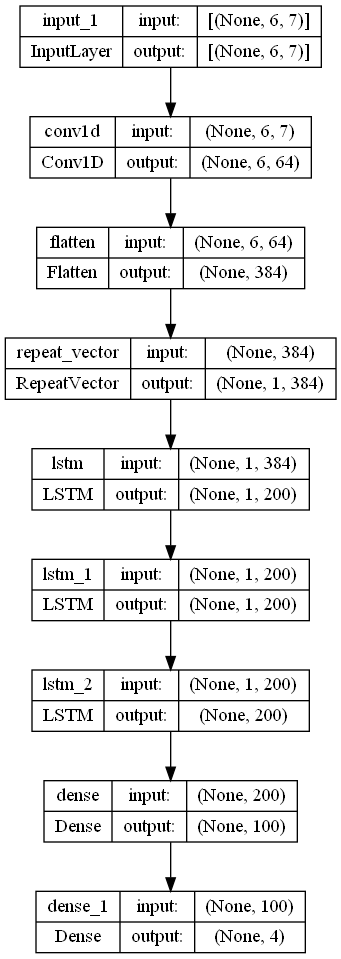

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

## 학습

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 22s 24ms/step - loss: 21.1031 - nse: 0.5366 - val_loss: 14.6803 - val_nse: 0.3998 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 19s 24ms/step - loss: 14.9002 - nse: 0.8796 - val_loss: 34.9510 - val_nse: -2.3331 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 19s 24ms/step - loss: 9.7435 - nse: 0.9626 - val_loss: 7.3760 - val_nse: 0.8465 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 19s 23ms/step - loss: 9.4552 - nse: 0.9670 - val_loss: 9.2284 - val_nse: 0.7480 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 19s 24ms/step - loss: 5.6013 - nse: 0.9880 - val_loss: 6.2558 - val_nse: 0.8823 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 19s 24ms/step - loss: 6.9721 - nse: 0.9826 - val_loss: 6.5721 - val_nse: 0.8750 - lr: 0.0100
Epoch 7/100
802/802 [==============================] - 18s 23ms/step - loss: 6.0902 - nse: 0.9870 - val_los

802/802 [==============================] - 16s 20ms/step - loss: 1.0910 - nse: 0.9996 - val_loss: 1.5102 - val_nse: 0.9945 - lr: 1.5625e-04
Epoch 56/100
802/802 [==============================] - 18s 23ms/step - loss: 1.0896 - nse: 0.9996 - val_loss: 1.6055 - val_nse: 0.9936 - lr: 1.5625e-04
Epoch 57/100
802/802 [==============================] - 17s 22ms/step - loss: 1.0840 - nse: 0.9996 - val_loss: 1.5705 - val_nse: 0.9937 - lr: 7.8125e-05
Epoch 58/100
802/802 [==============================] - 18s 22ms/step - loss: 1.0835 - nse: 0.9996 - val_loss: 1.5783 - val_nse: 0.9938 - lr: 7.8125e-05
Epoch 59/100
802/802 [==============================] - 17s 21ms/step - loss: 1.0848 - nse: 0.9996 - val_loss: 1.5689 - val_nse: 0.9936 - lr: 7.8125e-05
Epoch 60/100
802/802 [==============================] - 17s 22ms/step - loss: 1.0790 - nse: 0.9996 - val_loss: 1.5653 - val_nse: 0.9936 - lr: 3.9062e-05
Epoch 61/100
802/802 [==============================] - 18s 22ms/step - loss: 1.0794 - nse: 0.9

## 평가

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 1s 2ms/step - loss: 1.1488 - nse: 0.9899


[1.1487988233566284, 0.989857017993927]

## 학습 과정 시각화

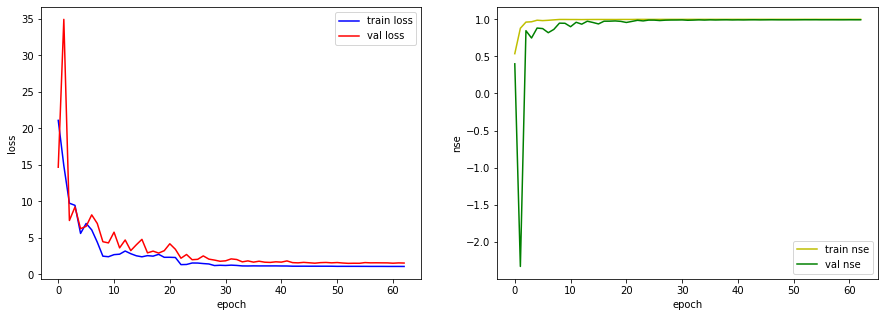

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

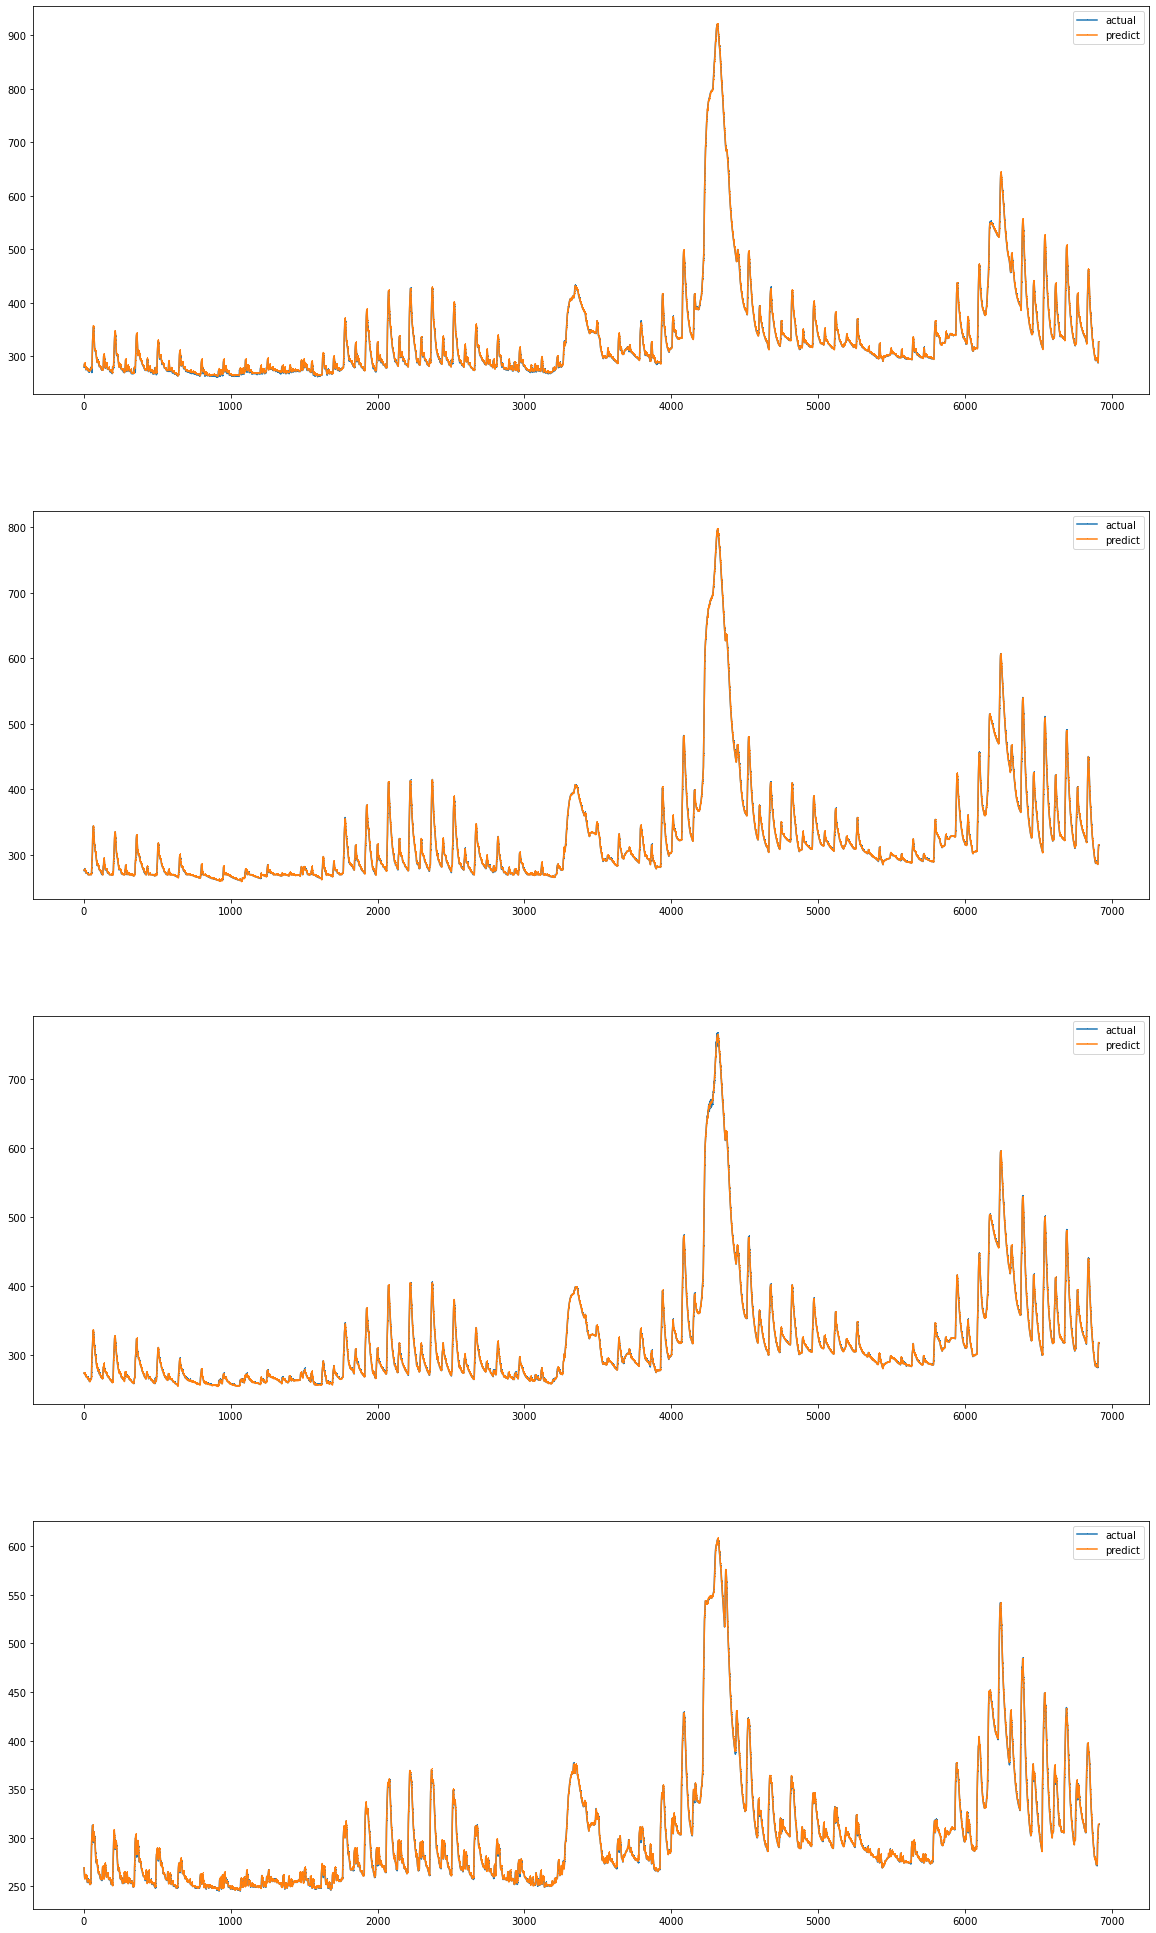

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [ ]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i])  / r2_score(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]) / r2_score(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.5802502254144646, shape=(), dtype=float64)
tf.Tensor(0.9240196948176661, shape=(), dtype=float64)
tf.Tensor(1.1033417751009587, shape=(), dtype=float64)
tf.Tensor(1.2496264944491924, shape=(), dtype=float64)
최종점수:  1.2143095474455703


## 파일 제출

In [ ]:
sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("한강대교_1.1.csv", index = False)

## 결과 해석

In [ ]:
!pip install eli5

In [ ]:
eli5.show_weights(keras_model_best)

In [ ]:
!pip install shap

In [ ]:
import shap
# SHAP model explainer
shap.initjs()

explainer = shap.DeepExplainer(keras_model_best, xtrain)
explainer

In [ ]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
shap_value = explainer.shap_values(xtest)

In [ ]:
shap_val = np.array(shap_value)

In [ ]:
a = np.absolute(shap_val[0])
b = np.sum(a, axis=1)
SHAP_list = [np.sum(b[:, 0]), np.sum(b[:, 1]), np.sum(b[:, 2]), np.sum(b[:, 3]), np.sum(b[:, 4])]
N_weight = normalize(weight_list)
N_SHAP = normalize(SHAP_list)